In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
from collections import defaultdict, Counter
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import (
    ToTensor, Normalize, Compose, Resize, CenterCrop, RandomCrop,
    RandomHorizontalFlip, RandomResizedCrop, RandomRotation)

from pathlib import Path
from typing import Callable, List
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

N_CLASSES = 1103
DATA_ROOT = Path('../input/imet-2019-fgvc6')

In [2]:
def make_folds(n_folds: int, seed: int) -> pd.DataFrame:
    df = pd.read_csv(DATA_ROOT / 'train.csv')
    # https://www.kaggle.com/seefun/imet-get-aspect-ratio
    def get_img_size(img_id, path):      
        img = Image.open(f'{path}{img_id}.png')
        return img.size
    df['shape'] = df['id'].apply(lambda x : get_img_size(x, '../input/imet-2019-fgvc6/train/'))
    df['width'] = [width for width,_ in df['shape'].values]
    df['height'] = [height for _,height in df['shape'].values]
    df['aspect_ratio'] = df.height/df.width
    cls_counts = Counter(cls for classes in df['attribute_ids'].str.split()
                         for cls in classes)
    fold_cls_counts = defaultdict(int)
    folds = [-1] * len(df)
    for item in tqdm.tqdm(df.sample(frac=1, random_state=seed).itertuples(),
                          total=len(df)):
        cls = min(item.attribute_ids.split(), key=lambda cls: cls_counts[cls])
        fold_counts = [(f, fold_cls_counts[f, cls]) for f in range(n_folds)]
        min_count = min([count for _, count in fold_counts])
        random.seed(item.Index)
        fold = random.choice([f for f, count in fold_counts
                              if count == min_count])
        folds[item.Index] = fold
        for cls in item.attribute_ids.split():
            fold_cls_counts[fold, cls] += 1
    df['fold'] = folds
    return df


def main():
    df = make_folds(n_folds=10, seed=42)
    df.to_csv('folds.csv', index=None)


if __name__ == '__main__':
    main()

100%|██████████| 109237/109237 [00:02<00:00, 45253.25it/s]


In [3]:
class TrainDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame,
                 image_transform: Callable, image_transform2: Callable, debug: bool = True):
        super().__init__()
        self._root = root
        self._df = df
        self._image_transform = image_transform
        self._image_transform2 = image_transform2
        self._debug = debug

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx: int):
        item = self._df.iloc[idx]
        if item.height>1000:
            image = load_transform_image(
            item, self._root, self._image_transform2, debug=self._debug)
        else:
            image = load_transform_image(
            item, self._root, self._image_transform, debug=self._debug)
        target = torch.zeros(N_CLASSES)
        for cls in item.attribute_ids.split():
            target[int(cls)] = 1
        return image, target, item.height


class TTADataset:
    def __init__(self, root: Path, df: pd.DataFrame,
                 image_transform: Callable, tta: int):
        self._root = root
        self._df = df
        self._image_transform = image_transform
        self._tta = tta

    def __len__(self):
        return len(self._df) * self._tta

    def __getitem__(self, idx):
        item = self._df.iloc[idx % len(self._df)]
        image = load_transform_image(item, self._root, self._image_transform)
        return image, item.id


def load_transform_image(
        item, root: Path, image_transform: Callable, debug: bool = False):
    image = load_image(item, root)
    image = image_transform(image)
    if debug:
        image.save('_debug.png')
    return tensor_transform(image)


def load_image(item, root: Path) -> Image.Image:
    image = cv2.imread(str(root / f'{item.id}.png'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(image)


def get_ids(root: Path) -> List[str]:
    return sorted({p.name.split('_')[0] for p in root.glob('*.png')})

In [4]:
train_root = DATA_ROOT / 'train'

def make_loader(df: pd.DataFrame, image_transform, image_transform2) -> DataLoader:
    return DataLoader(
            TrainDataset(train_root, df, image_transform, image_transform2, debug=False),
            shuffle=False,
            batch_size=1,
            num_workers=4,
        )

In [5]:
folds = pd.read_csv('folds.csv')
folds = folds.sort_values("height", ascending=False).reset_index(drop=True)
train_fold = folds[folds['fold'] != 0]
valid_fold = folds[folds['fold'] == 0]

In [6]:
train_fold.head(10)

,id,attribute_ids,shape,width,height,aspect_ratio,fold
1,755e9dfc355f41cc,188 1035,"(300, 5687)",300,5687,18.956667,8
2,6f778f9b79df0296,121 833,"(300, 3150)",300,3150,10.500000,5
3,c8e6d135c8fb84e6,194 1034,"(300, 3015)",300,3015,10.050000,1
4,ef3dec5a4d926396,396 1034,"(300, 3012)",300,3012,10.040000,2
5,8f84bc651353da27,188 1065,"(300, 2987)",300,2987,9.956667,4
6,8ee6ea818c70197c,51 672,"(300, 2816)",300,2816,9.386667,4
7,5be919b2d16ab9c0,41 833,"(300, 2779)",300,2779,9.263333,1
8,3857a43253d08492,784 1034 1092 369,"(300, 2657)",300,2657,8.856667,9
9,5522f1e69185b876,672 369,"(300, 2583)",300,2583,8.610000,5
10,c861de010d4ee735,292 552,"(300, 2541)",300,2541,8.470000,9


In [7]:
import numbers
import torchvision.transforms.functional as F

class RandomRotate(object):
    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        if random.random() < 0.5:
            angle = self.get_params(self.degrees)
            return F.rotate(img, angle, self.resample, self.expand, self.center)
        else:
            angle = random.uniform(0, 0)
            return F.rotate(img, angle, self.resample, self.expand, self.center)

    def __repr__(self):
        format_string = self.__class__.__name__ + '(degrees={0}'.format(self.degrees)
        format_string += ', resample={0}'.format(self.resample)
        format_string += ', expand={0}'.format(self.expand)
        if self.center is not None:
            format_string += ', center={0}'.format(self.center)
        format_string += ')'
        return format_string

In [8]:
train_transform = Compose([
    RandomCrop(288),
    RandomHorizontalFlip(),
])

train_transform2 = Compose([
    #Resize((288, 288)),
    RandomRotate((90, 90), expand=True),
    RandomCrop(288),
    RandomHorizontalFlip(),
])


test_transform = Compose([
    RandomCrop(288),
    RandomHorizontalFlip(),
])

tensor_transform = Compose([
    ToTensor(),
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# RandomRotation

In [9]:
train_loader = make_loader(train_fold, train_transform, train_transform2)

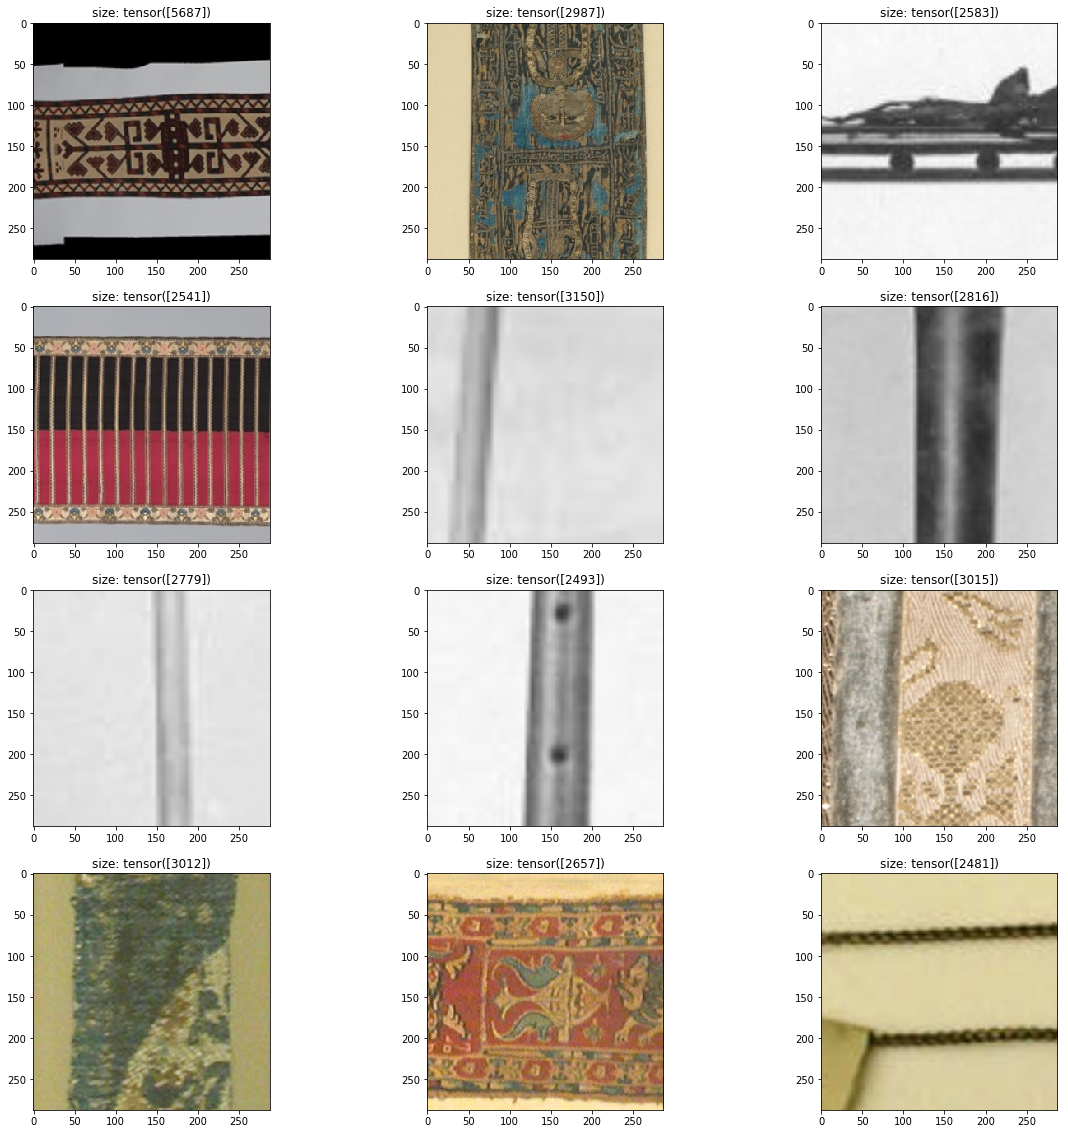

In [10]:
fig, ax = plt.subplots(4, 3, figsize=(20,20))
for i, (img, tar, size) in enumerate(train_loader):
    ax[i%4][i%3].imshow(transforms.ToPILImage()(img[-1,]))
    ax[i%4][i%3].set_title(f'size: {size}')
    if i == 4*3-1:
        break
fig.show()